In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import copy
import random
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
from resources.helper import PeakData, Isotopes
known_cys_fnam = 'resources/known_cys_labeled.tab'
# blacklist_fnam = 'resources/blacklist.tab'
blacklist_fnam = 'resources/blacklist-GSH-artifacts.tab'

# Read isotope information into an object:
IUPAC_atomic_masses = 'resources/IUPAC-atomic-masses.csv'
IUPAC_atomic_abundances = 'resources/IUPAC-atomic-abundances.html'
isotope_obj = Isotopes(IUPAC_atomic_masses, IUPAC_atomic_abundances)

# Adducts:
adducts_fnam = 'resources/adducts.tab'

## Define default parameters for peak filtering and peak pair finding

In [5]:
params = {
    ### Specify the formula for the isotopes in the labels used ###
    'labels': {
        'cys': '[13]C3 [15]N',
        'gly': '[13]C2',
        'gln': '[13]C5'
    },
    # End of isotope specification ################################

    ### Peak filter parameters ###
    'min_area': 1000,         # minimum peak area for at least one sample
    'min_area_label': 1000,   # minimum peak area for at least one labelled sample
    'min_MW': 120,            # minimum molecular weight of a compound (120 is one Da below Cysteine)
    'min_fold_blank': 4,      # minimum sample to blank peak area ratio
                              # i.e. max(sample)/max(blank) > min_fold_blank

    # Peak filter: peak merging #
    # Merge peaks within a ppm mass distance AND within
    # a retention time difference OR a retention time difference x2
    # AND over a minimum peak area correlation coefficient
    'merge_ppm_tol': 50,      # maximum mass distance (in ppm) between peaks to merge
    'merge_RT_tol': 0.1,      # maximum retention time difference between peaks to merge
    'merge_corr_tol':0.9,     # minimum peak area correlation coefficient
    # End of peak filter #########
    
    ### Peak pair finding ###
    'pair_ppm_tol': 10,            # maximum mass distance (in ppm) of expected mass shift between pairs
    'pair_RT_tol': 0.25,           # maximum retention time difference between pairs
    'pair_min_area': 1,            # minimum number of sample that pass the area ratio criterium

    # Range, or list of ranges, of labelled to unlabelled peak area ratios
    # within the accepted cutoff (ratio = labelled / sum(labelled, unlabelled))
    # These ratios are adjusted on an experiment-to-experiment basis (see below examples).
    'area_ratio_cutoff': {
        'cys': ((0.2, 0.28),
                (0.34, 0.42)),  # GSSG theoretical parent/(parent+heavy) is 0.25 with 50/50 labelled
        'gly': ((0.08, 0.24),),
        'gln': ((0.18, 0.6),),
    },
    # End of pair finding ###
    
    ### Peak pair filter parameters ###
    # Pair filter: adduct flagging #
    # Flag an adduct if it is within a ppm mass distance
    # and within a retention time difference
    # and has smaller total peak area than its parent ion
    'adduct_ppm_tol': 200,     # maximum mass distance (in ppm) to call adduct
    'adduct_RT_tol': 0.8,      # maximum retention time difference to call adduct

    # Pair filter: isotope flagging #
    # Flag an isotope if it is within a ppm mass distance
    # and within a retention time difference
    # and has a minimum peak area correlation coefficient
    # and has smaller total peak area than its parent ion
    'isotope_ppm_tol': 200,     # maximum mass distance (in ppm) to call isotope
    'isotope_RT_tol': 0.4,      # maximum retention time difference to call isotope
    'isotope_corr_tol':0.7,     # minimum peak area correlation coefficient to call isotope
    # End of peak pair filter #########

}

# Calculate the mass shift for each label:
params['MW_shift'] = dict()
for label in params['labels']:
    params['MW_shift'][label] = isotope_obj.isotopes2mass_shift(params['labels'][label])
print('Calculated mass shift for entered labels:')
pp.pprint(params['MW_shift'])

Calculated mass shift for entered labels:
{'cys': 4.007099400040005,
 'gln': 5.016774176699997,
 'gly': 2.0067096706799994}


## Cysteine tracing on metabolic fate of alkylating agents

Alkylating agents are known to react with glutathione, and other reactive thiols.
Thus, cysteine can be employed as a tracer of these thiol adducts.

Two 6-well plates were setup; one with 143B the other with SNU-308 cells.
At ~30 % confluency media was swapped to media with 50/50 labelled/unlabelled cystine.
Cells were then incubated for 24 hours before fresh media with 50/50 labelled/unlabelled cystine and one of the six alkylating agents were added.
Cells were then incubated with alkylating agents for another 4 hours before cell metabolites were harvested by removal of media, one wash in cold saline and extraction in 80 % methanol.


The alkylating agents were prepared fresh and added added from a stock solution to a final dose according to the table below.


| **Drug**     | **Formula**   | **Exact mass** | **Dose (uM)** | **Solubility**               | **Stock solution** | **Stock X** |
|--------------|---------------|----------------|---------------|------------------------------|--------------------|-------------|
| Thiotepa     | C6H12N3PS     |     189.048957 |          1000 | 100 mg/mL in H2O             | 500 mM in H2O      | 500x        |
| Temozolomide | C6H6N6O2      |     194.055224 |           100 | 38 mg/mL (195.72 mM) in DMSO | 100 mM in DMSO     | 1000x       |
| Altretamine  | C9H18N6       |     210.159294 |           100 | 11 mg/mL (52.31 mM) in DMSO  | 10 mM in DMSO      | 100x        |
| Carmustine   | C5H9Cl2N3O2   |     213.007183 |           100 | 100mM in DMSO                | 100 mM in DMSO     | 1000x       |
| Melphalan    | C13H18Cl2N2O2 |     304.074533 |            10 | 5 mg/mL in DMSO              | 10 mM in DMSO      | 1000x       |
| Chlorambucil | C14H19Cl2NO2  |     303.079285 |            10 | 60 mg/mL (197.23 mM) in DMSO | 10 mM in DMSO      | 1000x       |

In addition to these samples a set of blanks were made. Solvent blanks were made from the extraction solvent. Extraction blanks were made by performing metabolite extracting on a well without cells.

In [6]:
# Excel data filenames:
datafile_pos = 'projects/alkylation-agents/pos/alkylation-agents_cys-tracing_pos.xlsx'
datafile_neg = 'projects/alkylation-agents/neg/alkylation-agents_cys-tracing_neg.xlsx'

# Input information:
input_desc_fnam = 'projects/alkylation-agents/alkylation-agents.json'
# Since comments are not allowed in JSON format
# Use the eval function to turn this pseudo JSON into a dictionary:
input_desc = eval(open(input_desc_fnam, 'r').read())

# Read the data:
peak_obj = PeakData('alkylation-agents_cys-tracing', input_desc, params)

# Read peaks:
peak_obj.read_peaks(datafile_pos, 'pos')
peak_obj.read_peaks(datafile_neg, 'neg')

# Annotate known peaks:
peak_obj.annotate_known_peaks(known_cys_fnam, isotope_obj.formula2mass)

Running peak filtering for polarity: pos
Filtered 16829 peaks out based on.
Minimum peak area: 8603
Minimum molecular weight: 1019
Minimum fold over blank: 6971
Merged closely related peaks: 236
3278 peaks left.

Running peak filtering for polarity: neg
Filtered 8808 peaks out based on.
Minimum peak area: 5389
Minimum molecular weight: 322
Minimum fold over blank: 2977
Merged closely related peaks: 120
1636 peaks left.



### Adjust parameters for peak pair finding

In [7]:
# Find labelling ratio for known cysteine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_cys_fnam, 'pos', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),G6P Cys (m),G6P Cys (m+4),Glutamylcysteine (m),Glutamylcysteine (m+4),Conjugate EC = C3H3O2 (m),Conjugate EC = C3H3O2 (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4),GSH conjugate EC = C4H10NO (m),GSH conjugate EC = C4H10NO (m+4)
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.0
mean,0.745526,0.254474,0.621971,0.378029,0.752525,0.247475,0.782867,0.217133,0.782867,0.217133,0.887198,0.112802,0.785316,0.214684,0.369474,0.630526,0.782977,0.217023,0.5,0.5
std,0.010957,0.010957,0.023940,0.023940,0.101856,0.101856,0.031625,0.031625,0.031625,0.031625,0.043240,0.043240,0.027106,0.027106,0.093616,0.093616,0.016329,0.016329,0.0,0.0
min,0.725307,0.235451,0.572048,0.345138,0.435996,0.150405,0.727168,0.170664,0.727168,0.170664,0.776226,0.064580,0.744297,0.152728,0.248333,0.478978,0.761528,0.187097,0.5,0.5
25%,0.737746,0.245895,0.613761,0.367229,0.743118,0.191732,0.758771,0.192125,0.758771,0.192125,0.868235,0.081567,0.768533,0.205441,0.307386,0.554681,0.770047,0.202798,0.5,0.5
50%,0.742886,0.257114,0.628208,0.371792,0.765099,0.234901,0.785347,0.214653,0.785347,0.214653,0.896535,0.103465,0.786516,0.213484,0.333253,0.666747,0.779207,0.220793,0.5,0.5
75%,0.754105,0.262254,0.632771,0.386239,0.808268,0.256882,0.807875,0.241229,0.807875,0.241229,0.918433,0.131765,0.794559,0.231467,0.445319,0.692614,0.797202,0.229953,0.5,0.5
max,0.764549,0.274693,0.654862,0.427952,0.849595,0.564004,0.829336,0.272832,0.829336,0.272832,0.935420,0.223774,0.847272,0.255703,0.521022,0.751667,0.812903,0.238472,0.5,0.5


In [8]:
# Find labelling ratio for known cysteine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_cys_fnam, 'neg', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),G3P Cys (m),G3P Cys (m+4),DHAP Cys (m),DHAP Cys (m+4),Glutamylcysteine (m),Glutamylcysteine (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.751747,0.248253,0.630603,0.369397,0.812704,0.187296,0.812704,0.187296,0.789183,0.210817,0.777852,0.222148
std,0.012759,0.012759,0.087908,0.087908,0.044939,0.044939,0.044939,0.044939,0.036528,0.036528,0.047657,0.047657
min,0.737956,0.221440,0.513135,0.209915,0.718339,0.101159,0.718339,0.101159,0.752492,0.132892,0.700348,0.124377
25%,0.741070,0.239333,0.556198,0.304597,0.787665,0.164283,0.787665,0.164283,0.763938,0.190720,0.752562,0.196447
50%,0.748199,0.251801,0.617180,0.382820,0.824123,0.175877,0.824123,0.175877,0.775728,0.224272,0.770401,0.229599
75%,0.760667,0.258930,0.695403,0.443802,0.835717,0.212335,0.835717,0.212335,0.809280,0.236062,0.803553,0.247438
max,0.778560,0.262044,0.790085,0.486865,0.898841,0.281661,0.898841,0.281661,0.867108,0.247508,0.875623,0.299652


In [9]:
# Based on above analysis the cutoff is chosen:
peak_obj.params['area_ratio_cutoff']['cys'] = ((0.05, 0.70),)

# RT and MW tolerances are also adjusted:
peak_obj.params['pair_ppm_tol'] = 3
peak_obj.params['pair_RT_tol'] = 0.5

### Search for peak pairs and flag isotopes, adducts etc

In [10]:
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')

In [11]:
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')

In [12]:
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
pp.pprint(isotope_set)

{('[13]C',): {'abundance': 0.010599999999999998,
              'mass_shift': 1.0033548353399997},
 ('[13]C', '[13]C'): {'abundance': 0.00011235999999999996,
                      'mass_shift': 2.0067096706799994},
 ('[13]C', '[13]C', '[13]C'): {'abundance': 1.1910159999999995e-06,
                               'mass_shift': 3.010064506020001},
 ('[13]C', '[13]C', '[34]S'): {'abundance': 4.9045139999999985e-06,
                               'mass_shift': 4.00250550813999},
 ('[13]C', '[15]N'): {'abundance': 4.022699999999999e-05,
                      'mass_shift': 2.000389729360002},
 ('[13]C', '[15]N', '[34]S'): {'abundance': 1.7559085499999997e-06,
                               'mass_shift': 3.996185566820003},
 ('[13]C', '[17]O'): {'abundance': 4.065099999999999e-06,
                      'mass_shift': 2.00757197203},
 ('[13]C', '[18]O'): {'abundance': 2.1676999999999996e-05,
                      'mass_shift': 3.007599828220002},
 ('[13]C', '[2]H'): {'abundance': 1.5369999999999

In [13]:
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')

In [14]:
# Write results as Excel files:
peak_obj.write_pairs('projects/alkylation-agents/pos/alkylation-agents_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/alkylation-agents/neg/alkylation-agents_cys-tracing_pairs_neg', 'neg')

### Processing the results

At this point, all the results have been written to Excel files which provide an interface to further processing/filtering/plotting.

In the following, I will show how to indentify some of the cysteine metabolites that form after treating cells alkylating agents.

In [15]:
# Extract sample information from the input description JSON
# stored in the "group" tag:
name2info = {desc['name']: desc for desc in input_desc.values() if desc['type'] != 'blank'}
sample_info_df = pd.DataFrame.from_dict(name2info, orient='index')
sample_info_df[['Cell_line','Treatment']] = sample_info_df.group.str.split(', ', expand=True)
sample_info_df.head(4)

,name,order,type,label,group,Cell_line,Treatment
SNU308+Vec_1,SNU308+Vec_1,1,sample,cys,"SNU308, Vehicle",SNU308,Vehicle
SNU308+Vec_2,SNU308+Vec_2,2,sample,cys,"SNU308, Vehicle",SNU308,Vehicle
SNU308+TEPA,SNU308+TEPA,3,sample,cys,"SNU308, Thiotepa",SNU308,Thiotepa
SNU308+Temo,SNU308+Temo,5,sample,cys,"SNU308, Temozolomide",SNU308,Temozolomide


In [16]:
# We start in positive polarity:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos.head(4)

,pair_id,MW_parent,RT_parent,MW_heavy,RT_heavy,polarity,label,name,RT_diff,MW_ppm_diff,Isotopes,Adducts,Blacklist,known_anno,SNU308+Vec_1,SNU308+Vec_2,SNU308+TEPA,143B+TEPA,SNU308+Temo,143B+Temo,SNU308+Alt,143B+Alt,SNU308+Carm,143B+Carm,SNU308+Mel,143B+Mel,SNU308+Chlor,143B+Chlor
0,"((127.0382, 6.269), (131.04521, 6.268), pos, cys)",127.038,6.269,131.045,6.268,pos,cys,5-Amino-4-imidazolecarboxylate,0.001,0.703726,None,None,None,None,11206,12978,11800.3,5856.53,1.65709e+06,2.08311e+06,8706.38,7236.55,9656.77,7148.77,12222.5,6057.79,13479.3,7201.9
1,"((133.01989, 5.355), (137.02688, 5.313), pos, ...",133.02,5.355,137.027,5.313,pos,cys,Timonacic,0.042,0.822434,None,None,None,None,75880,85403.6,103046,184895,153573,252152,199642,195627,131939,214586,258534,294401,160677,261829
2,"((147.03464, 9.962), (151.04166, 10.158), pos,...",147.035,9.962,151.042,10.158,pos,cys,NaN,0.196,0.540009,None,"[(31, M+2Na)]",None,None,2065.21,2104.72,1584.43,6667.54,2021.1,6205.52,1803.63,5457.64,1834.64,3362.48,2082.84,7056.89,7250.81,5579.42
3,"((147.03551, 4.104), (151.04252, 4.076), pos, ...",147.036,4.104,151.043,4.076,pos,cys,Thiomorpholine3-carboxylate,0.028,0.608017,None,None,None,None,1.47416e+06,1.65359e+06,1.44824e+06,2.31168e+06,113078,2.53093e+06,1.68282e+06,2.08231e+06,1.289e+06,251007,1.97882e+06,3.00019e+06,1.72904e+06,2.51917e+06


In [17]:
def flat_df(df_pol, sample_info_df):
    # Now let's get rid of the adducts, isotopes and blacklisted peaks:
    mask = (df_pol['Isotopes'].isnull() & df_pol['Adducts'].isnull() & df_pol['Blacklist'].isnull()) | ~df_pol['known_anno'].isnull()
    df_pol = df_pol[mask]

    # And flatten the data for easy sorting/filtering/plotting:
    df_pol_flat = pd.melt(df_pol, id_vars=['MW_parent', 'RT_parent', 'Adducts', 'known_anno'], value_vars=list(name2info.keys()), var_name='sample', value_name='area')
    # Add MW_RT string:
    df_pol_flat['MW_RT_anno'] = [str(mw)+'_'+str(rt)+'_'+str(anno) for mw, rt, anno in zip(df_pol_flat['MW_parent'].values, df_pol_flat['RT_parent'].values, df_pol_flat['known_anno'].values)]
    # Add sample info:
    df_pol_flat = df_pol_flat.merge(sample_info_df.loc[:, ['name', 'Cell_line', 'Treatment']], left_on='sample', right_on='name')
    # Drop unnecessary columns:
    df_pol_flat = df_pol_flat.drop(['name'], axis=1)

    return(df_pol, df_pol_flat)

df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)
df_pos_flat.head(3)

,MW_parent,RT_parent,Adducts,known_anno,sample,area,MW_RT_anno,Cell_line,Treatment
0,127.038,6.269,None,None,SNU308+Vec_1,11206,127.0382_6.269_None,SNU308,Vehicle
1,133.02,5.355,None,None,SNU308+Vec_1,75880,133.01989_5.355_None,SNU308,Vehicle
2,147.036,4.104,None,None,SNU308+Vec_1,1.47416e+06,147.03551_4.104_None,SNU308,Vehicle


In [18]:
sample_grp = {
"Vehicle": ['SNU308+Vec_1', 'SNU308+Vec_2'],
"TEPA": ['SNU308+TEPA', '143B+TEPA'],
"Temo": ['SNU308+Temo', '143B+Temo'],
"Alt": ['SNU308+Alt', '143B+Alt'],
"Carm": ['SNU308+Carm', '143B+Carm'],
"Mel": ['SNU308+Mel', '143B+Mel'],
"Chlor": ['SNU308+Chlor', '143B+Chlor']
}

In [19]:
# Filter peak pairs based on presence in any of the samples
# treated with alkylating agents and absence in the vehicle
# treated samples:
def filter_pairs(df_pol, sample_grp):
    fold_inc = 4
    mask_union = df_pol['pair_id'].isnull()
    for drug in sample_grp:
        if drug == 'Vehicle':
            continue
        vec_area = df_pol.loc[:, sample_grp['Vehicle']].mean(1)
        # drug_area = df_pol.loc[:, sample_grp[drug]].mean(1)
        # mask = drug_area / vec_area >= fold_inc
        drug_area_SNU308 = df_pol.loc[:, sample_grp[drug][0]]
        drug_area_SNU143B = df_pol.loc[:, sample_grp[drug][1]]
        mask = (drug_area_SNU308 / vec_area >= fold_inc) & (drug_area_SNU143B / vec_area >= fold_inc)

        mask_union = mask_union | mask
    print('Number of potential alkylation conjugates found: {}'.format(mask_union.sum()))
    
    return(mask_union)

In [20]:
# Show the filtered peak pairs and add a color gradient
# to each row based on the peak areas in the row:
mask_union_pos = filter_pairs(df_pos, sample_grp)
area_cols = [s for d in sample_grp.values() for s in d]
sele_cols = ['MW_parent', 'RT_parent', 'known_anno'] + area_cols
df_pos.loc[mask_union_pos, sele_cols].style.background_gradient(subset=area_cols, axis=1)

Number of potential alkylation conjugates found: 7


,MW_parent,RT_parent,known_anno,SNU308+Vec_1,SNU308+Vec_2,SNU308+TEPA,143B+TEPA,SNU308+Temo,143B+Temo,SNU308+Alt,143B+Alt,SNU308+Carm,143B+Carm,SNU308+Mel,143B+Mel,SNU308+Chlor,143B+Chlor
0,127.038200,6.269000,None,11205.980688,12978.007341,11800.336916,5856.534908,1657086.103396,2083110.576724,8706.375329,7236.550977,9656.774554,7148.774585,12222.505272,6057.785023,13479.292747,7201.897107
21,190.041210,7.899000,None,2275.344733,2441.464763,2329.850858,1825.915341,2069.260377,1807.364813,2467.163005,1956.402896,88481.957339,167296.217512,2325.070965,1763.227176,2350.972844,1953.973007
26,226.017900,5.856000,None,454.271049,380.474334,382.254944,421.111155,403.157272,471.724861,402.112176,589.260567,57467.465835,1307892.723044,385.292669,465.079127,431.325626,576.422987
47,310.068660,5.162000,None,313.072345,300.775605,31581.275123,77236.533868,272.644671,284.338319,362.085417,315.855273,294.805440,313.187749,293.747478,292.754809,305.914044,289.874971
63,350.125990,11.516000,None,343.208503,350.009613,101320.546029,11898.656398,317.537478,280.955777,336.985131,312.215446,355.132697,289.821629,363.174540,295.976217,328.114321,278.764552
76,412.082090,7.962000,None,7493.531684,8393.769777,7891.005189,6450.174928,7240.922071,6430.286764,8438.755362,6911.131432,199482.880921,4568305.202259,7937.192705,6656.484801,8304.977648,6902.547679
80,496.133400,6.684000,None,4805.724315,4623.839111,636703.384776,108692.176175,5220.672439,7459.953730,5693.451686,7377.455480,5555.921376,8175.712071,5469.299343,7722.951307,5483.394736,7649.481140


The results of tracing in positive polarity gave 7 potential alkylation conjugates.
For several of these, they are clearly only present in conditions with one of the alkylation agents and thus are likely conjugates.
But before looking into that let's do the same for negative polarity.

In [21]:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
df_neg, df_neg_flat = flat_df(df_neg, sample_info_df)

mask_union_neg = filter_pairs(df_neg, sample_grp)
area_cols = [s for d in sample_grp.values() for s in d]
sele_cols = ['MW_parent', 'RT_parent', 'known_anno'] + area_cols
df_neg.loc[mask_union_neg, sele_cols].style.background_gradient(subset=area_cols, axis=1)

Number of potential alkylation conjugates found: 6


,MW_parent,RT_parent,known_anno,SNU308+Vec_1,SNU308+Vec_2,SNU308+TEPA,143B+TEPA,SNU308+Temo,143B+Temo,SNU308+Alt,143B+Alt,SNU308+Carm,143B+Carm,SNU308+Mel,143B+Mel,SNU308+Chlor,143B+Chlor
0,121.019760,5.917000,None,720.693528,992.088496,614.100288,854.278927,1170.065625,795.554349,650.978384,1341.107302,4511.285668,105573.358453,674.355698,955.744291,599.683601,1647.003849
1,133.019740,5.357000,None,9693.166250,9569.528831,15774.848616,35247.624712,24358.228023,49558.780023,30528.488622,31016.107947,17754.345025,35616.718753,40277.449625,43326.450263,25077.612193,43598.067606
27,307.083700,8.017000,GSH,696.971386,2469.960830,698.586924,447.619559,740.788333,453.031538,2570.674458,544.262097,95956.588120,2112296.124246,2923.453839,718.543171,3138.030515,493.616353
54,350.125650,11.549000,None,177.022541,171.523626,69145.625941,7419.830460,164.852539,174.572798,163.758877,170.583114,540.471167,178.626991,172.698863,176.227088,169.435915,180.771015
61,412.081840,8.017000,None,556.243897,560.095411,557.231174,357.239412,589.022000,347.529870,622.160812,434.368578,14840.942705,461850.755304,617.772780,398.786061,555.376214,393.948861
64,496.132740,6.785000,None,1367.740307,1315.040847,182369.521793,26689.439384,1262.739611,1458.694227,1306.516494,1441.826580,1384.119282,1389.144436,1385.599879,1511.505312,1294.690071,1539.355466


To annotate the potential alkylation cysteine conjugates, we could start by searching for metabolic breakdown products described in previous publications and add them to a list of known cys labelled compounds under: `resources/known_alkylation-agent_conjugates/known_cys_labeled.tab`


**Chlorambucil and Melphalan**  
There are several examples in the literature that suggest the existence of both mono and di glutathionylated Chlorambucil, as well as other nitrogen mustard derivative such as Melphalan (see [Hansson et al. 1991](https://paperpile.com/shared/oKQ6O4) and [Paumi et al. 2001](https://paperpile.com/shared/55R7aV)).
The Wikipedia page on [Chlorambucil](https://en.wikipedia.org/wiki/Chlorambucil) shows the conjugation to glutathione via. GST like below:
<img src="resources/known_alkylation-agent_conjugates/Chlorambucil_glutathione_reaction.png" alt="Chlorambucil glutathione reaction" width="500"/>

I therefore added both mono and di glutathionylated Chlorambucil and Melphalan to the list of known cys labelled compounds.


**Thiotepa**  
For Thiotepa, the breakdown can be mediated by glutathione.
According to [Li et al 2011](https://paperpile.com/shared/2znlTq) via. mono glutathionylated thiotepa, broken down to cysteinyl thiotepa which is then N-acetylated:
<img src="resources/known_alkylation-agent_conjugates/thiotepa/thiotepa_breakdown.png" alt="Thiotepa breakdown" width="600"/>

It follows that if one of the three aziridine rings on thiotepa can be glutathionylated, it is likely that the others can too.
I therefore added the breakdown products shown above and mono, di and tri glutathionylated thiotepa to the list of known cys labelled compounds.

Thiotepa can also spontaneously hydrolyze to produce free aziridine rings which act as electrophiles in alkylation reactions.
Alkylation reactions are typically described between nucleophiles such as nitrogenous bases in DNA (see [Musser et al. 1992](https://paperpile.com/shared/ksXg77)), but free thiols can also act as nucleophiles for example in the reaction with glutathione:
<img src="resources/known_alkylation-agent_conjugates/thiotepa/thiotepa_breakdown2.png" alt="Thiotepa breakdown" width="400"/>

I therefore added aziridine ring alkylation products with glutathione, cysteine and N-acetyl cysteine to the list of known cys labelled compounds.


**Altretamine**  
Although Altretamine is classified as an alkylating agent chemotherapy its mechanism of action is unknown and no obvious cysteine conjugates exists.


**Carmustine**  
Carmustine is part of the nitrosoureas group of alkylating agants.
It decomposes under physiological conditions with a half-life of ~60 min yielding 2-chloroethyl isocyanate (CEIC).
CEIC is an electrophile that can react spontaneously with free thiols, like those on glutathione and cysteine.
The cysteine containing breakdown products of carmustine, and other nitrosourea alkylating agants, is described by [Davis et al 1993](https://paperpile.com/shared/vgQ60Q) and in a later [chapter](https://paperpile.com/shared/LxrvpM) of Methods in Enzymology.
The reaction is described as formation of chloroethyl isocyanate, carbamoylation of the glutathione thiol to make CEIC GSH, breakdown of this to make CEIC Cys and finally N-acetylation to form CEIC NAC:
<img src="resources/known_alkylation-agent_conjugates/carmustine/carmustine_breakdown.png" alt="Carmustine breakdown" width="900"/>
I added CEIC GSH, CEIC Cys and CEIC NAC to the list of known cys labelled compounds.


**Temozolomide**  
Temozolomide is a prodrug that gets hydrolyzed and further broken down before being an aktive alkylating agent.
Although [Rocha et al. 2016](https://paperpile.com/shared/lRCZDd) suggest interplay between glutathione and temozolomide, no breakdown products that include glutathione or cysteine have been described.


Now reprocess with the new annotations added.

In [22]:
# Annotate known peaks:
peak_obj.annotate_known_peaks('resources/known_alkylation-agent_conjugates/known_cys_labeled.tab', isotope_obj.formula2mass)
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')
# Write results as Excel files:
peak_obj.write_pairs('projects/alkylation-agents/pos/alkylation-agents_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/alkylation-agents/neg/alkylation-agents_cys-tracing_pairs_neg', 'neg')

In [23]:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)

mask_union_pos = filter_pairs(df_pos, sample_grp)
area_cols = [s for d in sample_grp.values() for s in d]
sele_cols = ['MW_parent', 'RT_parent', 'known_anno'] + area_cols
df_pos.loc[mask_union_pos, sele_cols].style.background_gradient(subset=area_cols, axis=1)

Number of potential alkylation conjugates found: 7


,MW_parent,RT_parent,known_anno,SNU308+Vec_1,SNU308+Vec_2,SNU308+TEPA,143B+TEPA,SNU308+Temo,143B+Temo,SNU308+Alt,143B+Alt,SNU308+Carm,143B+Carm,SNU308+Mel,143B+Mel,SNU308+Chlor,143B+Chlor
0,127.038200,6.269000,None,11205.980688,12978.007341,11800.336916,5856.534908,1657086.103396,2083110.576724,8706.375329,7236.550977,9656.774554,7148.774585,12222.505272,6057.785023,13479.292747,7201.897107
21,190.041210,7.899000,None,2275.344733,2441.464763,2329.850858,1825.915341,2069.260377,1807.364813,2467.163005,1956.402896,88481.957339,167296.217512,2325.070965,1763.227176,2350.972844,1953.973007
26,226.017900,5.856000,CEIC Cys (Carmustine),454.271049,380.474334,382.254944,421.111155,403.157272,471.724861,402.112176,589.260567,57467.465835,1307892.723044,385.292669,465.079127,431.325626,576.422987
47,310.068660,5.162000,Thiotepa Cys,313.072345,300.775605,31581.275123,77236.533868,272.644671,284.338319,362.085417,315.855273,294.805440,313.187749,293.747478,292.754809,305.914044,289.874971
63,350.125990,11.516000,GSH aziridine (Thiotepa),343.208503,350.009613,101320.546029,11898.656398,317.537478,280.955777,336.985131,312.215446,355.132697,289.821629,363.174540,295.976217,328.114321,278.764552
76,412.082090,7.962000,CEIC GSH (Carmustine),7493.531684,8393.769777,7891.005189,6450.174928,7240.922071,6430.286764,8438.755362,6911.131432,199482.880921,4568305.202259,7937.192705,6656.484801,8304.977648,6902.547679
80,496.133400,6.684000,Thiotepa GSH,4805.724315,4623.839111,636703.384776,108692.176175,5220.672439,7459.953730,5693.451686,7377.455480,5555.921376,8175.712071,5469.299343,7722.951307,5483.394736,7649.481140


In [24]:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
df_neg, df_neg_flat = flat_df(df_neg, sample_info_df)

mask_union_neg = filter_pairs(df_neg, sample_grp)
area_cols = [s for d in sample_grp.values() for s in d]
sele_cols = ['MW_parent', 'RT_parent', 'known_anno'] + area_cols
df_neg.loc[mask_union_neg, sele_cols].style.background_gradient(subset=area_cols, axis=1)

Number of potential alkylation conjugates found: 6


,MW_parent,RT_parent,known_anno,SNU308+Vec_1,SNU308+Vec_2,SNU308+TEPA,143B+TEPA,SNU308+Temo,143B+Temo,SNU308+Alt,143B+Alt,SNU308+Carm,143B+Carm,SNU308+Mel,143B+Mel,SNU308+Chlor,143B+Chlor
0,121.019760,5.917000,None,720.693528,992.088496,614.100288,854.278927,1170.065625,795.554349,650.978384,1341.107302,4511.285668,105573.358453,674.355698,955.744291,599.683601,1647.003849
1,133.019740,5.357000,None,9693.166250,9569.528831,15774.848616,35247.624712,24358.228023,49558.780023,30528.488622,31016.107947,17754.345025,35616.718753,40277.449625,43326.450263,25077.612193,43598.067606
27,307.083700,8.017000,GSH,696.971386,2469.960830,698.586924,447.619559,740.788333,453.031538,2570.674458,544.262097,95956.588120,2112296.124246,2923.453839,718.543171,3138.030515,493.616353
54,350.125650,11.549000,GSH aziridine (Thiotepa),177.022541,171.523626,69145.625941,7419.830460,164.852539,174.572798,163.758877,170.583114,540.471167,178.626991,172.698863,176.227088,169.435915,180.771015
61,412.081840,8.017000,CEIC GSH (Carmustine),556.243897,560.095411,557.231174,357.239412,589.022000,347.529870,622.160812,434.368578,14840.942705,461850.755304,617.772780,398.786061,555.376214,393.948861
64,496.132740,6.785000,Thiotepa GSH,1367.740307,1315.040847,182369.521793,26689.439384,1262.739611,1458.694227,1306.516494,1441.826580,1384.119282,1389.144436,1385.599879,1511.505312,1294.690071,1539.355466


With the known annotation added there remains 4 peak pairs unannotated, plus one peak with GSH annotation at the wrong retention time.
Let us look at them individually in order of molecular weight (MW), first positive then negative polarity.

**MW=127.038200, RT=6.269000, Polarity=pos**  
This peak pair is specific to temozolomide treated samples but it is of light molecular mass compared to cysteine i.e. it is hard to imagine it as a cysteine conjugate.
Let us look at the peak areas for the labelled (m+4) peak:

In [25]:
peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].loc[:, ['MW_parent', 'RT_parent', 'SNU308+Vec_1', 'SNU308+Vec_2', 'SNU308+Temo', '143B+Temo']].head(1)

,MW_parent,RT_parent,SNU308+Vec_1,SNU308+Vec_2,SNU308+Temo,143B+Temo
0,127.038,6.269,9454.17,11278.4,16261.9,33287.4


The labelled peak is not much above background in the temozolomide treated samples.
The labelling ratio is also very low.

In [26]:
peak_obj.label_pairs['cys']['pos']['peak_pair_labelp'].loc[:, ['MW_parent', 'RT_parent', 'SNU308+Vec_1', 'SNU308+Vec_2', 'SNU308+Temo', '143B+Temo']].head(1)

,MW_parent,RT_parent,SNU308+Vec_1,SNU308+Vec_2,SNU308+Temo,143B+Temo
0,127.038,6.269,0.457604,0.464967,0.0097182,0.0157283


Upon detailed inspection the parent peak (MW=127.0382) is derived from the main temozolomide breakdown product 5-aminoimidazole-4-carboxamide (AIC, MW=126.0541), see [Wikipedia](https://en.wikipedia.org/wiki/Temozolomide#Pharmacokinetics).
The amide in AIC is hydrolyzed during ionization (in-source) to give 5-aminoimidazole-4-carboxylate (MW=127.0382) which is the parent mass to the peak pair.
The m+4 peak that pairs to the parent peak has nothing to do with temozolomide and indeed it is equally abundant in vehicle treated samples.


**MW=190.041210, RT=7.899000, Polarity=pos**  
This peak pair is specific to carmustine treated samples.
Given its retention time and molecular weight it is most likely an in-source fragment of MW=412.082090, RT=7.962000, CEIC GSH (Carmustine).
Probably with the formula: C6H10N2O3S


**MW=121.019760, RT=5.917000, Polarity=neg**  
This peak pair is specific to carmustine treated samples.
The parent molecular weight is the same as cysteine:

In [27]:
isotope_obj.formula2mass('C3 H7 N O2 S')

121.019749639596

And given its retention time it is most likely the de-carbamoylation of CEIC Cys i.e. an in-source fragment of MW=226.017900, RT=5.856000, CEIC Cys (Carmustine)


**MW=133.019740, RT=5.357000, Polarity=neg**  
This peak pair is not specific to any particlular samples but it is more abundant in samples treated with alkylating agents.
The parent molecular weight is the same as the compound timonacic (or thioproline):

In [28]:
isotope_obj.formula2mass('C4 H7 N O2 S')

133.019749639596

Timonacic can be formed by a reaction between cysteine and formaldehyde, as described in [Kallen 1970](https://paperpile.com/shared/QJdk5D).
Thus, an increase in cysteine or formaldehyde would likely lead to higher timonacic concentration which could explain the increase in samples treated with alkylating agents.



**MW=307.083700, RT=8.017000, Polarity=neg**  
This peak pair is specific to carmustine treated samples.
The parent molecular weight is the same as glutathione (as the "known_anno" column suggests):

In [29]:
isotope_obj.formula2mass('C10 H17 N3 O6 S')

307.083806444116

And given its retention time it is most likely the de-carbamoylation of CEIC GSH i.e. an in-source fragment of MW=412.082090, RT=7.962000, CEIC GSH (Carmustine)

Now reprocess with the new annotations added.

In [30]:
# Annotate known peaks:
peak_obj.annotate_known_peaks('resources/known_alkylation-agent_conjugates/known_cys_labeled_upd.tab', isotope_obj.formula2mass)
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')
# Write results as Excel files:
peak_obj.write_pairs('projects/alkylation-agents/pos/alkylation-agents_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/alkylation-agents/neg/alkylation-agents_cys-tracing_pairs_neg', 'neg')

Finally, let's check out the labelling of some of the compounds discovered above.
Here shown for positive polarity.

In [31]:
# Data, no label:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)

# Data, cysteine label (m+4):
df_pos_m4 = peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].copy()
df_pos_m4, df_pos_flat_m4 = flat_df(df_pos_m4, sample_info_df)

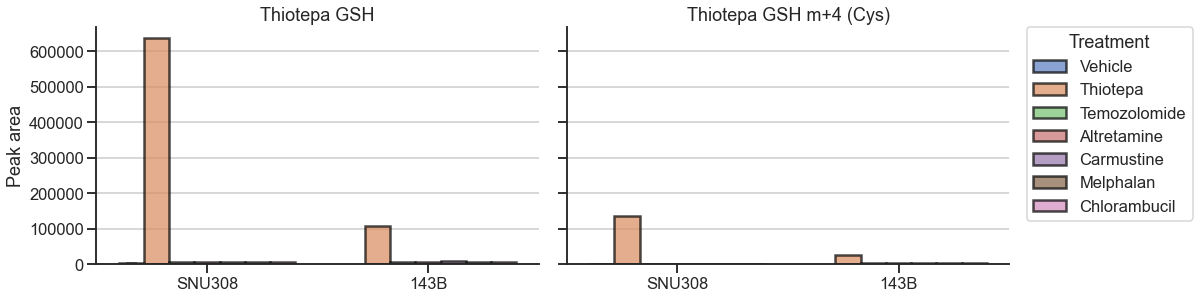

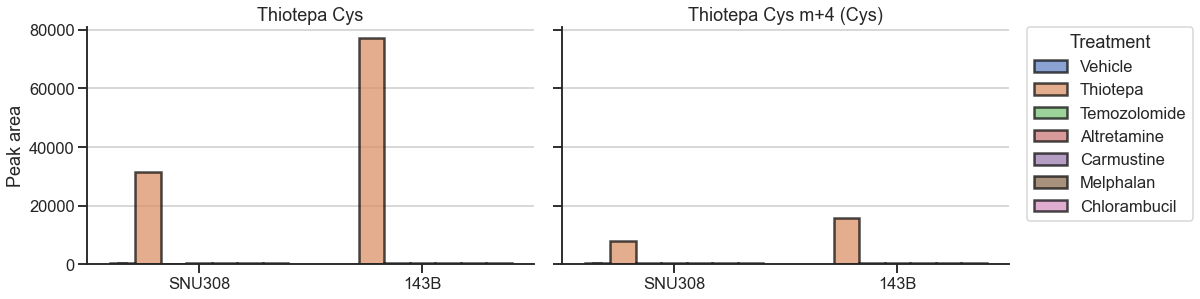

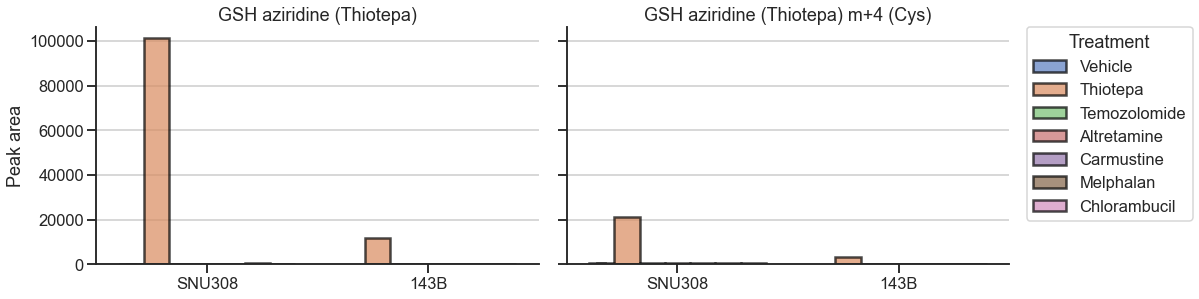

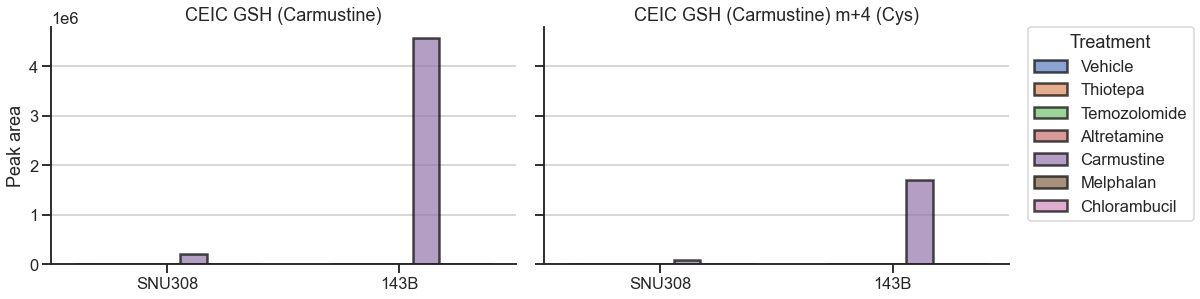

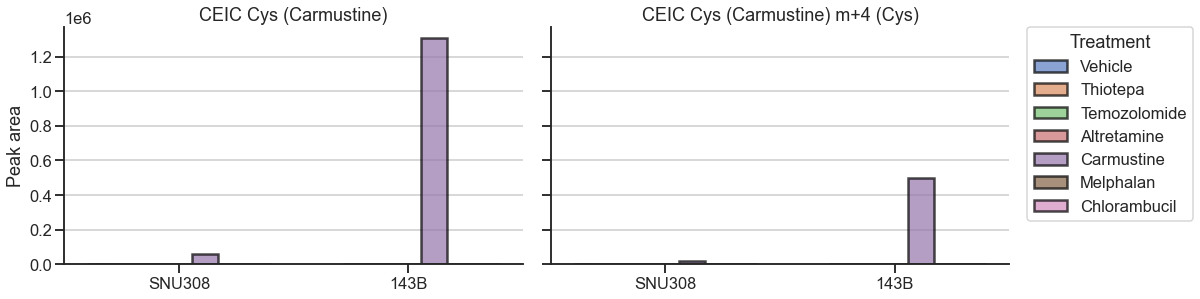

In [32]:
# Plotting:
for peak_id, name in zip(['496.1334_6.684_Thiotepa GSH', '310.06866_5.162_Thiotepa Cys', '350.12599_11.516_GSH aziridine (Thiotepa)', '412.08209_7.962_CEIC GSH (Carmustine)', '226.0179_5.856_CEIC Cys (Carmustine)'], ['Thiotepa GSH', 'Thiotepa Cys', 'GSH aziridine (Thiotepa)', 'CEIC GSH (Carmustine)', 'CEIC Cys (Carmustine)']):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id)
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id)
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Cell_line', hue='Treatment', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')

    sns.despine()
    fig.tight_layout()